# Preprocessing

In [1]:
#!pip install xgboost

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter

In [3]:
# Get dataset
data = pd.read_csv('data/2015.csv')

In [4]:
data.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENUM,...,_PAREC1,_PASTAE1,_LMTACT1,_LMTWRK1,_LMTSCL1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
0,1.0,1.0,b'01292015',b'01',b'29',b'2015',1200.0,2.015000e+09,2.015000e+09,1.0,...,4.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0
1,1.0,1.0,b'01202015',b'01',b'20',b'2015',1100.0,2.015000e+09,2.015000e+09,1.0,...,2.0,2.0,3.0,3.0,4.0,2.0,2.0,NaN,NaN,2.0
2,1.0,1.0,b'02012015',b'02',b'01',b'2015',1200.0,2.015000e+09,2.015000e+09,1.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,NaN
3,1.0,1.0,b'01142015',b'01',b'14',b'2015',1100.0,2.015000e+09,2.015000e+09,1.0,...,4.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,9.0
4,1.0,1.0,b'01142015',b'01',b'14',b'2015',1100.0,2.015000e+09,2.015000e+09,1.0,...,4.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0


In [5]:
data.shape

(441456, 330)

In [6]:
# Get number of null values
num_of_null_values = data.isnull().sum().sum()
print(num_of_null_values)

64809261


In [7]:
# Check how many values are there in the dataset - Minimum 10M values required
num_of_values = data.shape[0] * data.shape[1] - num_of_null_values
print(num_of_values)

80871219


In [8]:
# Create a copy of the data dataframe
dataset = data.copy()

In [9]:
# Check number of values for CVDINFR4 (heart attack column) are the same in the codebook
'''
1 - Yes
2 - No
7 - Don't Know/Not sure
9 - Refused
'''
dataset['CVDINFR4'].value_counts()

2.0    413755
1.0     25472
7.0      2038
9.0       191
Name: CVDINFR4, dtype: int64

In [10]:
# Drop empty columns
dataset.dropna(inplace=True, axis=1, how='all')

In [11]:
dataset.shape

(441456, 326)

In [12]:
# Drop columns where all values are the same. This means there is no variation in the data. Check for columns where std = 0. 
std_indices = dataset.std()[(dataset.std() == 0)].index
dataset.drop(std_indices, axis=1, inplace=True)

In [13]:
dataset.shape

(441456, 321)

In [14]:
# Drop columns that start with '_' since those are mostly columns derived from other columns
# Keep the following columns: _RACE, _FRUTSUM, _VEGESUM, _BMI5CAT, _PACAT1
for col in dataset.columns:
    if col.startswith('_') and col != "_RACE" and col != "_FRUTSUM" and col != "_VEGESUM" and col != "_BMI5CAT" and col != "_PACAT1":
        dataset.drop(col, axis=1, inplace = True)

In [15]:
dataset.shape

(441456, 250)

In [16]:
# Drop columns with 95% of missing values
dataset = dataset.loc[:, dataset.isnull().sum() < 0.95*dataset.shape[0]]

In [17]:
dataset.shape

(441456, 185)

In [18]:
# Check datatype of each column
dataset.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441456 entries, 0 to 441455
Data columns (total 185 columns):
 #   Column    Dtype  
---  ------    -----  
 0   FMONTH    float64
 1   IDATE     object 
 2   IMONTH    object 
 3   IDAY      object 
 4   IYEAR     object 
 5   DISPCODE  float64
 6   SEQNO     float64
 7   PVTRESD1  float64
 8   CELLFON3  float64
 9   NUMADULT  float64
 10  NUMMEN    float64
 11  NUMWOMEN  float64
 12  CELLFON2  float64
 13  CADULT    float64
 14  PVTRESD2  float64
 15  CSTATE    float64
 16  LANDLINE  float64
 17  HHADULT   float64
 18  GENHLTH   float64
 19  PHYSHLTH  float64
 20  MENTHLTH  float64
 21  POORHLTH  float64
 22  HLTHPLN1  float64
 23  PERSDOC2  float64
 24  MEDCOST   float64
 25  CHECKUP1  float64
 26  BPHIGH4   float64
 27  BPMEDS    float64
 28  BLOODCHO  float64
 29  CHOLCHK   float64
 30  TOLDHI2   float64
 31  CVDINFR4  float64
 32  CVDCRHD4  float64
 33  CVDSTRK3  float64
 34  ASTHMA3   float64
 35  ASTHNOW   float64
 36  CHCSCNCR 

In [19]:
# Check how many values are empty in EXACTOT1 column. 
dataset[dataset['EXACTOT1'] == "b''"].EXACTOT1.count()

428378

In [20]:
# Check how many values are empty in EXACTOT2 column.
dataset[dataset['EXACTOT2'] == "b''"].EXACTOT2.count()

424831

In [21]:
# Check how many values are empty in PCDMDECN column. 
dataset[dataset['PCDMDECN'] == "b''"].PCDMDECN.count()

441201

In [22]:
# Keep columns with datatype float64 to keep columns with categorical values only. 
# Columns IDATE, IMONTH, IDAY, and IYEAR can be drop as they represent the interview date which is irrelevant for predictions
dataset = dataset.select_dtypes(include=['float64'])

In [23]:
# Check columns have datatype float64 only.
dataset.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441456 entries, 0 to 441455
Data columns (total 178 columns):
 #   Column    Dtype  
---  ------    -----  
 0   FMONTH    float64
 1   DISPCODE  float64
 2   SEQNO     float64
 3   PVTRESD1  float64
 4   CELLFON3  float64
 5   NUMADULT  float64
 6   NUMMEN    float64
 7   NUMWOMEN  float64
 8   CELLFON2  float64
 9   CADULT    float64
 10  PVTRESD2  float64
 11  CSTATE    float64
 12  LANDLINE  float64
 13  HHADULT   float64
 14  GENHLTH   float64
 15  PHYSHLTH  float64
 16  MENTHLTH  float64
 17  POORHLTH  float64
 18  HLTHPLN1  float64
 19  PERSDOC2  float64
 20  MEDCOST   float64
 21  CHECKUP1  float64
 22  BPHIGH4   float64
 23  BPMEDS    float64
 24  BLOODCHO  float64
 25  CHOLCHK   float64
 26  TOLDHI2   float64
 27  CVDINFR4  float64
 28  CVDCRHD4  float64
 29  CVDSTRK3  float64
 30  ASTHMA3   float64
 31  ASTHNOW   float64
 32  CHCSCNCR  float64
 33  CHCOCNCR  float64
 34  CHCCOPD1  float64
 35  HAVARTH3  float64
 36  ADDEPEV2 

In [24]:
dataset.shape

(441456, 178)

In [25]:
# Get rows where CVDINFR4 = 1 or 2 from the dataset. Ignore rows where CVDINFR4 = 7 or 9.
dataset = dataset.loc[dataset['CVDINFR4'].isin([1, 2])]
dataset.reset_index(drop=True, inplace=True)

In [26]:
dataset['CVDINFR4']

0         2.0
1         2.0
2         2.0
3         2.0
4         2.0
         ... 
439222    2.0
439223    2.0
439224    2.0
439225    2.0
439226    1.0
Name: CVDINFR4, Length: 439227, dtype: float64

In [27]:
# Get labels from the dataset
labels = dataset[['CVDINFR4']].astype(int)

In [28]:
labels

,CVDINFR4
0,2
1,2
2,2
3,2
4,2
...,...
439222,2
439223,2
439224,2
439225,2


In [29]:
# Change labels to 0 - No heart attack and 1 - heart attack. Values with 1 stay the same. Change '2' values to '0'
labels['CVDINFR4'].replace(2, 0, inplace=True)

In [30]:
labels

,CVDINFR4
0,0
1,0
2,0
3,0
4,0
...,...
439222,0
439223,0
439224,0
439225,0


In [31]:
# Remove the labels (CVDINFR4 column) from the dataset
dataset.drop(['CVDINFR4'], axis=1, inplace=True)

In [32]:
dataset.shape

(439227, 177)

In [33]:
# Check correlation of columns using a correlation matrix. For this fill in NA values first.
# Followed the code in this page: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
dataset2 = dataset.fillna(-1)
correlation_matrix = dataset2.corr().abs()

In [34]:
correlation_matrix

,FMONTH,DISPCODE,SEQNO,PVTRESD1,CELLFON3,NUMADULT,NUMMEN,NUMWOMEN,CELLFON2,CADULT,...,PAFREQ2_,STRFREQ_,PAMISS1_,PAMIN11_,PAMIN21_,PA1MIN_,PAVIG11_,PAVIG21_,PA1VIGM_,_PACAT1
FMONTH,1.000000,0.005900,0.248180,0.009287,0.007349,0.006565,0.005249,0.008961,0.009304,0.009132,...,0.010122,0.009287,0.005422,0.023855,0.016107,0.026305,0.019205,0.017343,0.024217,0.010844
DISPCODE,0.005900,1.000000,0.053581,0.141937,0.139455,0.128497,0.124509,0.130212,0.141970,0.134712,...,0.120111,0.104059,0.712436,0.106318,0.074454,0.118678,0.077802,0.061844,0.092725,0.539209
SEQNO,0.248180,0.053581,1.000000,0.577408,0.561521,0.529077,0.510644,0.534488,0.577448,0.557141,...,0.003498,0.018010,0.041829,0.012906,0.010715,0.015470,0.037989,0.026710,0.043540,0.019998
PVTRESD1,0.009287,0.141937,0.577408,1.000000,0.957589,0.915411,0.883331,0.926192,0.999946,0.967078,...,0.013308,0.036003,0.045033,0.028431,0.025837,0.035428,0.071841,0.054345,0.084563,0.023141
CELLFON3,0.007349,0.139455,0.561521,0.957589,1.000000,0.876805,0.846202,0.887446,0.957650,0.926173,...,0.012086,0.038112,0.046359,0.022974,0.023650,0.030323,0.065982,0.050852,0.078222,0.022645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PA1MIN_,0.026305,0.118678,0.015470,0.035428,0.030323,0.028866,0.035245,0.023895,0.035450,0.038762,...,0.419968,0.126556,0.155062,0.800362,0.733061,1.000000,0.642443,0.567011,0.802483,0.400646
PAVIG11_,0.019205,0.077802,0.037989,0.071841,0.065982,0.052011,0.055973,0.053975,0.071856,0.070802,...,0.147447,0.066329,0.087364,0.811041,0.134088,0.642443,1.000000,0.139947,0.815504,0.237882
PAVIG21_,0.017343,0.061844,0.026710,0.054345,0.050852,0.040238,0.041529,0.042807,0.054366,0.052981,...,0.294320,0.050789,0.068445,0.151378,0.758758,0.567011,0.139947,1.000000,0.687180,0.185891
PA1VIGM_,0.024217,0.092725,0.043540,0.084563,0.078222,0.061723,0.065371,0.064696,0.084586,0.082998,...,0.279677,0.077962,0.103383,0.683262,0.541704,0.802483,0.815504,0.687180,1.000000,0.282035


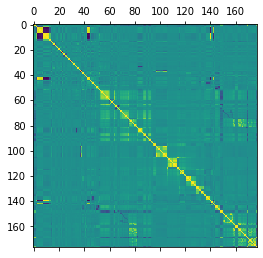

In [35]:
plt.matshow(dataset2.corr())
plt.show()

In [36]:
# Get correlations from the upper triangle in the correlation matrix
utriangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))

In [37]:
utriangle

,FMONTH,DISPCODE,SEQNO,PVTRESD1,CELLFON3,NUMADULT,NUMMEN,NUMWOMEN,CELLFON2,CADULT,...,PAFREQ2_,STRFREQ_,PAMISS1_,PAMIN11_,PAMIN21_,PA1MIN_,PAVIG11_,PAVIG21_,PA1VIGM_,_PACAT1
FMONTH,NaN,0.0059,0.248180,0.009287,0.007349,0.006565,0.005249,0.008961,0.009304,0.009132,...,0.010122,0.009287,0.005422,0.023855,0.016107,0.026305,0.019205,0.017343,0.024217,0.010844
DISPCODE,NaN,NaN,0.053581,0.141937,0.139455,0.128497,0.124509,0.130212,0.141970,0.134712,...,0.120111,0.104059,0.712436,0.106318,0.074454,0.118678,0.077802,0.061844,0.092725,0.539209
SEQNO,NaN,NaN,NaN,0.577408,0.561521,0.529077,0.510644,0.534488,0.577448,0.557141,...,0.003498,0.018010,0.041829,0.012906,0.010715,0.015470,0.037989,0.026710,0.043540,0.019998
PVTRESD1,NaN,NaN,NaN,NaN,0.957589,0.915411,0.883331,0.926192,0.999946,0.967078,...,0.013308,0.036003,0.045033,0.028431,0.025837,0.035428,0.071841,0.054345,0.084563,0.023141
CELLFON3,NaN,NaN,NaN,NaN,NaN,0.876805,0.846202,0.887446,0.957650,0.926173,...,0.012086,0.038112,0.046359,0.022974,0.023650,0.030323,0.065982,0.050852,0.078222,0.022645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PA1MIN_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.642443,0.567011,0.802483,0.400646
PAVIG11_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.139947,0.815504,0.237882
PAVIG21_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.687180,0.185891
PA1VIGM_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.282035


In [38]:
# Find columns with correlation greater than 0.90
high_correlated_columns = [col for col in utriangle.columns if any (utriangle[col] > 0.90)]

In [39]:
high_correlated_columns

['CELLFON3',
 'NUMADULT',
 'NUMMEN',
 'NUMWOMEN',
 'CELLFON2',
 'CADULT',
 'PVTRESD2',
 'CSTATE',
 'LANDLINE',
 'BPMEDS',
 'NUMHHOL2',
 'CPDEMO1',
 'ARTHSOCL',
 'EYEEXAM',
 'DIABEYE',
 'DIABEDU',
 'CRGVHOUS',
 'CRGVMST2',
 'DRADVISE',
 'HADPAP2',
 'HADHYST2',
 'HADSIGM3',
 'LASTSIG3',
 'SCNTMEL1',
 'QSTVER',
 'HTM4',
 'DROCDY3_',
 'FC60_']

In [40]:
# Drop high correlated columns from the dataset
dataset.drop(high_correlated_columns, axis=1, inplace=True)

In [41]:
for col in dataset.columns:
    print(col)

FMONTH
DISPCODE
SEQNO
PVTRESD1
HHADULT
GENHLTH
PHYSHLTH
MENTHLTH
POORHLTH
HLTHPLN1
PERSDOC2
MEDCOST
CHECKUP1
BPHIGH4
BLOODCHO
CHOLCHK
TOLDHI2
CVDCRHD4
CVDSTRK3
ASTHMA3
ASTHNOW
CHCSCNCR
CHCOCNCR
CHCCOPD1
HAVARTH3
ADDEPEV2
CHCKIDNY
DIABETE3
DIABAGE2
SEX
MARITAL
EDUCA
RENTHOM1
VETERAN3
EMPLOY1
CHILDREN
INCOME2
INTERNET
WEIGHT2
HEIGHT3
PREGNANT
QLACTLM2
USEEQUIP
BLIND
DECIDE
DIFFWALK
DIFFDRES
DIFFALON
SMOKE100
SMOKDAY2
STOPSMK2
LASTSMK2
USENOW3
ALCDAY5
AVEDRNK2
DRNK3GE5
MAXDRNKS
FRUITJU1
FRUIT1
FVBEANS
FVGREEN
FVORANG
VEGETAB1
EXERANY2
EXRACT11
EXEROFT1
EXERHMM1
EXRACT21
EXEROFT2
EXERHMM2
STRENGTH
LMTJOIN3
ARTHDIS2
JOINPAIN
SEATBELT
FLUSHOT6
FLSHTMY2
IMFVPLAC
PNEUVAC3
HIVTST6
HIVTSTD3
WHRTST10
PDIABTST
PREDIAB1
INSULIN
BLDSUGAR
FEETCHK2
DOCTDIAB
CHKHEMO3
FEETCHK
CAREGIV1
CRGVREL1
CRGVLNG1
CRGVHRS1
CRGVPRB1
CRGVPERS
CRGVEXPT
CIMEMLOS
WTCHSALT
LONGWTCH
TETANUS
SHINGLE2
HADMAM
HPVTEST
BLDSTOOL
HADSGCO1
SCNTMNY1
SCNTPAID
SCNTWRK1
SCNTLPAD
SCNTLWK1
SXORIENT
TRNSGNDR
RCSGENDR
RCSRLTN2
CASTHDX2
Q

In [42]:
# Drop other columns not related to health manually
dataset.drop(columns = ['FMONTH','DISPCODE','SEQNO','PVTRESD1','HHADULT'], axis=1, inplace = True)

In [43]:
dataset.shape

(439227, 144)

In [44]:
# Normalize dataset
scaler = StandardScaler()
dataset_norm = scaler.fit_transform(dataset)

In [45]:
dataset_norm

array([[ 2.17532449, -1.23331316, -1.30286436, ...,         nan,
                nan,  0.30328738],
       [ 0.38154116,  0.73675761,  0.65013274, ..., -0.2682094 ,
        -0.41586533, -0.50782117],
       [ 2.17532449, -0.8285041 , -0.96806486, ...,         nan,
                nan,  0.30328738],
       ...,
       [ 1.27843282,  0.73675761, -1.24706444, ...,         nan,
                nan,  2.33105877],
       [ 0.38154116,  0.73675761,  0.65013274, ...,         nan,
                nan,  0.30328738],
       [-0.51535051,  0.73675761,  0.65013274, ..., -0.2682094 ,
        -0.41586533, -0.10226689]])

In [46]:
# Get feature importance using XGBClassifier from XGBoost
# Followed the code in this page: https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

# Divide data in training and test
X_train, X_test, y_train, y_test = train_test_split(dataset_norm, labels, shuffle=True, test_size=0.2, random_state=42)
X_train_df = pd.DataFrame(data = X_train, columns=dataset.columns)
X_train_df.head()

,GENHLTH,PHYSHLTH,MENTHLTH,POORHLTH,HLTHPLN1,PERSDOC2,MEDCOST,CHECKUP1,BPHIGH4,BLOODCHO,...,PAFREQ2_,STRFREQ_,PAMISS1_,PAMIN11_,PAMIN21_,PA1MIN_,PAVIG11_,PAVIG21_,PA1VIGM_,_PACAT1
0,-0.515351,-1.584148,0.650133,0.845488,-0.197973,-0.474695,0.204616,-0.459962,-1.170248,-0.264305,...,NaN,NaN,0.071890,-0.255574,NaN,-0.408596,0.032425,NaN,-0.130901,2.331059
1,0.381541,0.736758,0.650133,NaN,-0.197973,-0.474695,0.204616,-0.459962,-1.170248,-0.264305,...,-0.041870,0.354003,-0.325957,4.215158,2.622902,4.676152,-0.351060,3.522167,1.863847,-0.913375
2,-0.515351,0.736758,-1.749264,-1.150390,-0.197973,-0.474695,0.204616,-0.459962,-1.170248,-0.264305,...,-0.669446,-0.532143,-0.325957,-0.398867,-0.253683,-0.428774,-0.351060,-0.268209,-0.415865,-0.507821
3,0.381541,-1.530173,-1.526064,-1.202914,-0.197973,-0.474695,-2.230236,-0.459962,-1.170248,-0.264305,...,NaN,-0.532143,-0.325957,NaN,NaN,NaN,NaN,NaN,NaN,0.303287
4,0.381541,0.736758,0.650133,NaN,-0.197973,0.728851,0.204616,-0.459962,0.763487,0.832724,...,NaN,NaN,3.254665,NaN,NaN,NaN,NaN,NaN,NaN,2.331059


In [47]:
# Fit model
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train_df, y_train)

[02:14:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=24, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

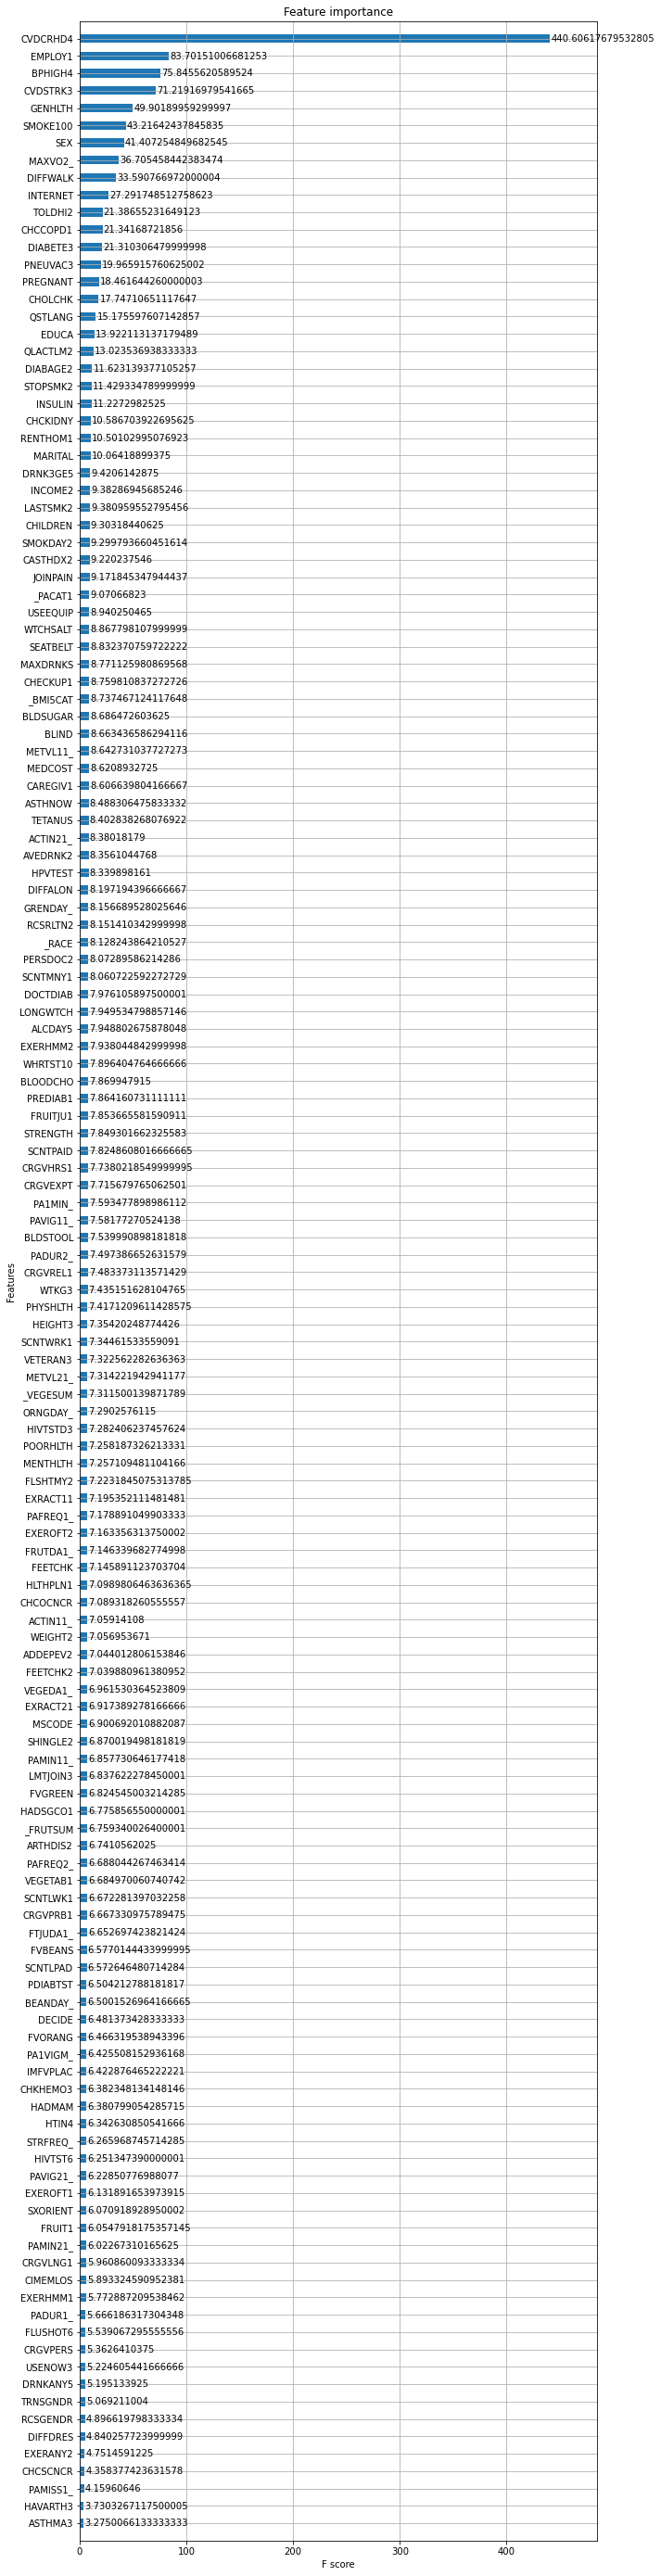

In [48]:
# Plot feature importance
ax = plot_importance(model, height=0.5, importance_type="gain")

fig = ax.figure
fig.set_size_inches(10, 50)

In [49]:
y_true, y_pred = y_test, model.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     82801
           1       0.60      0.31      0.41      5045

    accuracy                           0.95     87846
   macro avg       0.78      0.65      0.69     87846
weighted avg       0.94      0.95      0.94     87846



In [50]:
# Need to reduce the number of False Negatives (FN) when 1 is Positive in order to increase the recall score 
# and have more True Positive (TP) values because I am interested in predicting when a person CAN have a Heart attack.

In [51]:
# Accuracy is high because most '0's (not heart attack) are being predicted correctly. This occurs because only 5045 rows are 
# predicting '1's (heart attack) while a lot more rows 82801 are predicting '0's (not heart attack) meaning the data is
# skewed/imbalanced.

In [52]:
# Trying to fix the imbalanced classification
# Followed the code from this page: https://machinelearningmastery.com/xgboost-for-imbalanced-classification/

# Estimate scale_pos_weight value
counter = Counter(y_pred)
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 33.221


In [53]:
model = XGBClassifier(use_label_encoder=False, scale_pos_weight=33)
model.fit(X_train_df, y_train)

[02:15:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=24, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=33, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

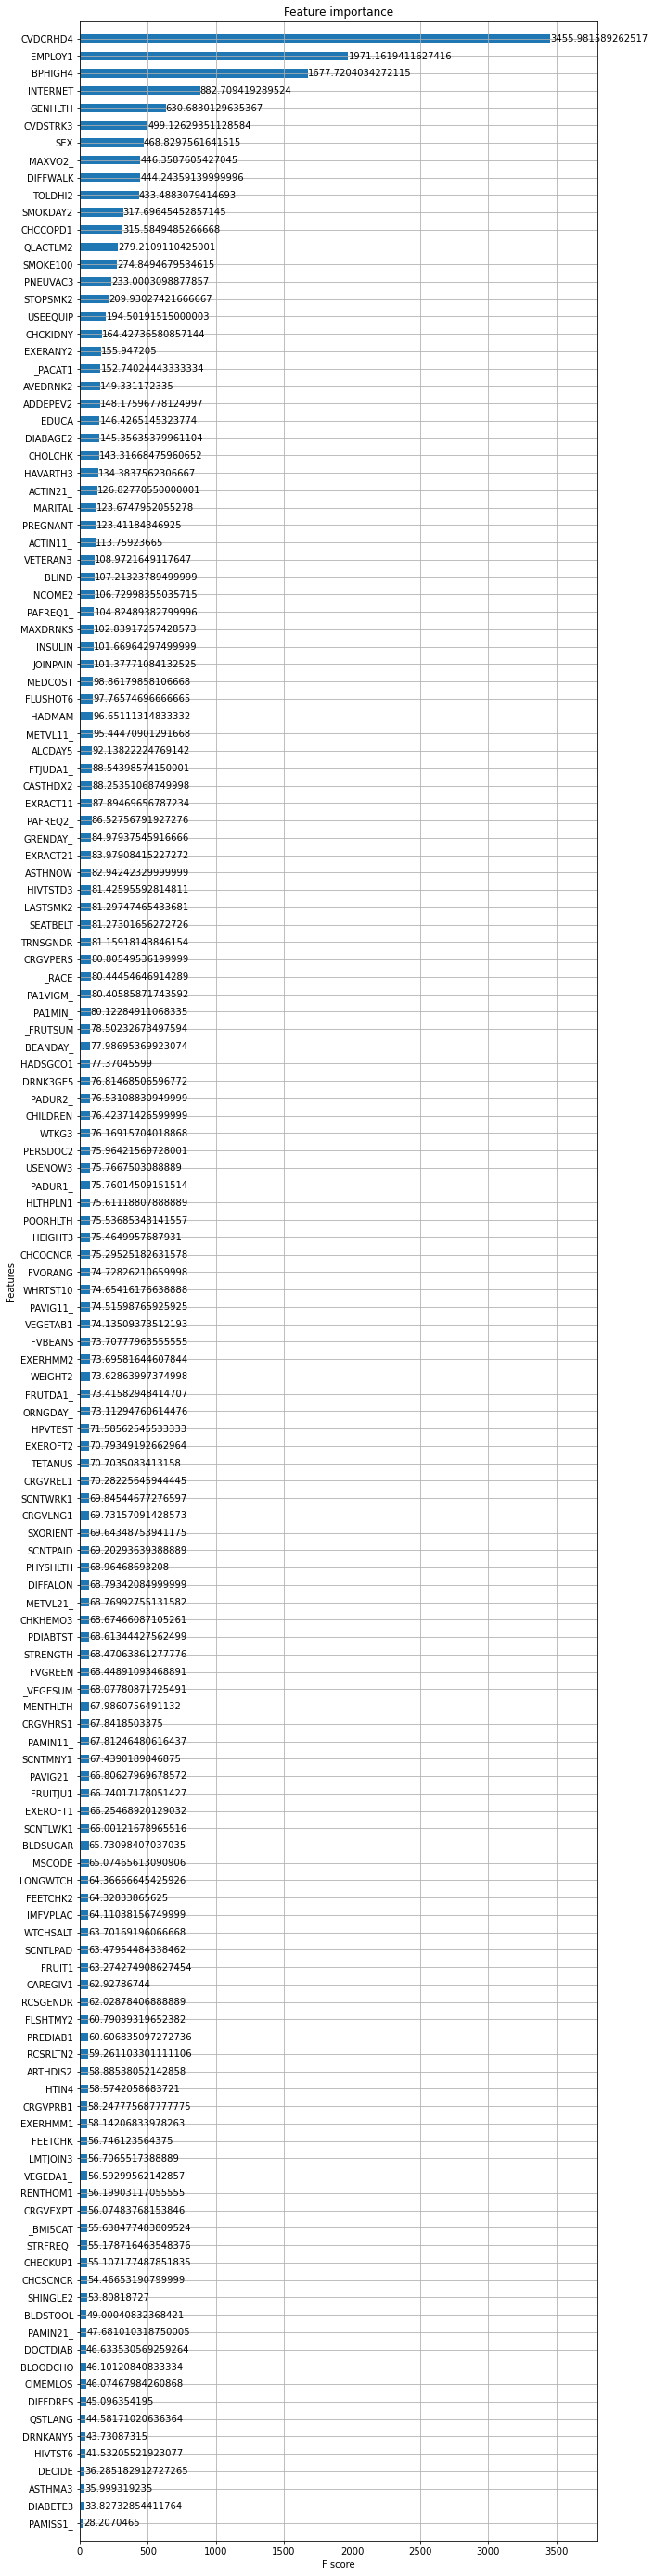

In [54]:
# Plot feature importance
ax = plot_importance(model, height=0.5, importance_type="gain")

fig = ax.figure
fig.set_size_inches(10, 50)

In [55]:
y_true, y_pred = y_test, model.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.76      0.86     82801
           1       0.18      0.84      0.29      5045

    accuracy                           0.76     87846
   macro avg       0.58      0.80      0.57     87846
weighted avg       0.94      0.76      0.83     87846



In [56]:
# Even though accuracy is lower after setting the class imbalance hyperparameter, the recall values are significantly higher.
# In this case having higher recall values is important to make sure samples with susceptibility of Heart Attack are
# classified correctly.

In [57]:
# Take only first 50 important features and check recall
sorted_indices = model.feature_importances_.argsort()
imp_features = dataset.columns[sorted_indices][-50:]

In [59]:
imp_features

Index(['HIVTSTD3', 'ASTHNOW', 'EXRACT21', 'GRENDAY_', 'PAFREQ2_', 'EXRACT11',
       'CASTHDX2', 'FTJUDA1_', 'ALCDAY5', 'METVL11_', 'HADMAM', 'FLUSHOT6',
       'MEDCOST', 'JOINPAIN', 'INSULIN', 'MAXDRNKS', 'PAFREQ1_', 'INCOME2',
       'BLIND', 'VETERAN3', 'ACTIN11_', 'PREGNANT', 'MARITAL', 'ACTIN21_',
       'HAVARTH3', 'CHOLCHK', 'DIABAGE2', 'EDUCA', 'ADDEPEV2', 'AVEDRNK2',
       '_PACAT1', 'EXERANY2', 'CHCKIDNY', 'USEEQUIP', 'STOPSMK2', 'PNEUVAC3',
       'SMOKE100', 'QLACTLM2', 'CHCCOPD1', 'SMOKDAY2', 'TOLDHI2', 'DIFFWALK',
       'MAXVO2_', 'SEX', 'CVDSTRK3', 'GENHLTH', 'INTERNET', 'BPHIGH4',
       'EMPLOY1', 'CVDCRHD4'],
      dtype='object')

In [60]:
imp_features_dataset = dataset[imp_features]

In [61]:
imp_features_dataset.head()

,HIVTSTD3,ASTHNOW,EXRACT21,GRENDAY_,PAFREQ2_,EXRACT11,CASTHDX2,FTJUDA1_,ALCDAY5,METVL11_,...,TOLDHI2,DIFFWALK,MAXVO2_,SEX,CVDSTRK3,GENHLTH,INTERNET,BPHIGH4,EMPLOY1,CVDCRHD4
0,NaN,1.0,NaN,33.0,NaN,NaN,NaN,1.700000e+01,888.0,NaN,...,1.0,1.0,2469.0,2.0,2.0,5.0,2.0,1.0,8.0,2.0
1,NaN,NaN,69.0,29.0,2800.0,64.0,NaN,7.000000e+00,888.0,35.0,...,2.0,2.0,2876.0,2.0,2.0,3.0,1.0,3.0,3.0,2.0
2,NaN,NaN,NaN,3.0,NaN,NaN,NaN,5.397605e-79,888.0,NaN,...,1.0,1.0,2469.0,2.0,2.0,5.0,2.0,1.0,8.0,2.0
3,777777.0,NaN,NaN,57.0,NaN,NaN,NaN,NaN,888.0,NaN,...,2.0,2.0,2543.0,2.0,2.0,5.0,1.0,3.0,8.0,2.0
4,NaN,NaN,73.0,100.0,7000.0,18.0,NaN,1.000000e+02,888.0,50.0,...,2.0,2.0,2099.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0


In [62]:
# Normalize dataset
imp_features_dataset_norm = scaler.fit_transform(imp_features_dataset)

In [63]:
# Divide data in training and test
X_train, X_test, y_train, y_test = train_test_split(imp_features_dataset_norm, labels, shuffle=True, test_size=0.2, random_state=42)

In [64]:
# Important feature model training and prediction
model1 = XGBClassifier(use_label_encoder=False, scale_pos_weight=33)
model1.fit(X_train, y_train)
y_true, y_pred = y_test, model1.predict(X_test)
print(classification_report(y_true, y_pred))

[02:15:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.99      0.74      0.85     82801
           1       0.17      0.86      0.28      5045

    accuracy                           0.75     87846
   macro avg       0.58      0.80      0.56     87846
weighted avg       0.94      0.75      0.81     87846



In [65]:
# Check current dataset shape
imp_features_dataset.shape

(439227, 50)

In [66]:
# Insert back the labels to the dataset
imp_features_dataset.insert(len(imp_features_dataset.columns), 'CVDINFR4', labels)

In [67]:
# Check dataset shape after labels insertion
imp_features_dataset.shape

(439227, 51)

In [69]:
imp_features_dataset.to_csv('preprocessed_dataset.csv', index=False)

## Next Section Needed to Explain Visualization

In [78]:
# Check ages for widowed people
data[data['MARITAL']==3]._AGEG5YR.value_counts()

13.0    21301
12.0     9909
11.0     8635
10.0     6792
9.0      4321
8.0      2467
7.0      1296
14.0      606
6.0       554
5.0       285
4.0       165
3.0        98
2.0        31
1.0        21
Name: _AGEG5YR, dtype: int64

In [ ]:
# Conclusion: Widowed people are usually old

In [79]:
# Check ages for never married people
data[data['MARITAL']==5]._AGEG5YR.value_counts()

1.0     19402
2.0      9340
3.0      6008
8.0      4710
7.0      4698
9.0      4362
4.0      4218
6.0      3633
5.0      3370
10.0     3230
11.0     1878
13.0     1141
12.0     1064
14.0      614
Name: _AGEG5YR, dtype: int64

In [ ]:
# Conclusion: Never married people are usually young